## EDA on Chicago Taxi data using BigQuery

**Initial Setup**

In [134]:
import os
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Set the OS environment variable
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "C:/Users/ragha/iCloudDrive/Documents/MSAnalytics/Q4/BigData/Lecture9/Code/firstsparkcluster-247900-8106b878b3bf.json"

#Ensure environment variable has been set
print(os.environ['GOOGLE_APPLICATION_CREDENTIALS'])

C:/Users/ragha/iCloudDrive/Documents/MSAnalytics/Q4/BigData/Lecture9/Code/firstsparkcluster-247900-8106b878b3bf.json


In [3]:
client = bigquery.Client()

### Load Reference to Taxi Trips dataset

In [4]:
taxi_dataset_ref = client.dataset('chicago_taxi_trips',project='bigquery-public-data')

In [6]:
taxi_dset = client.get_dataset(taxi_dataset_ref)

In [7]:
tables = list(client.list_tables(taxi_dset))

In [8]:
for table in tables:
    print(table.table_id)

taxi_trips


In [9]:
taxi_trips = client.get_table(taxi_dset.table('taxi_trips'))

### Taxi Trips Table Schema

In [11]:
taxi_trips.schema

[SchemaField('unique_key', 'STRING', 'REQUIRED', 'Unique identifier for the trip.', ()),
 SchemaField('taxi_id', 'STRING', 'REQUIRED', 'A unique identifier for the taxi.', ()),
 SchemaField('trip_start_timestamp', 'TIMESTAMP', 'NULLABLE', 'When the trip started, rounded to the nearest 15 minutes.', ()),
 SchemaField('trip_end_timestamp', 'TIMESTAMP', 'NULLABLE', 'When the trip ended, rounded to the nearest 15 minutes.', ()),
 SchemaField('trip_seconds', 'INTEGER', 'NULLABLE', 'Time of the trip in seconds.', ()),
 SchemaField('trip_miles', 'FLOAT', 'NULLABLE', 'Distance of the trip in miles.', ()),
 SchemaField('pickup_census_tract', 'INTEGER', 'NULLABLE', 'The Census Tract where the trip began. For privacy, this Census Tract is not shown for some trips.', ()),
 SchemaField('dropoff_census_tract', 'INTEGER', 'NULLABLE', 'The Census Tract where the trip ended. For privacy, this Census Tract is not shown for some trips.', ()),
 SchemaField('pickup_community_area', 'INTEGER', 'NULLABLE', '

### Count the number of trips in the table

In [12]:
QUERY = ('''
    SELECT count(*) 
    FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
''')

query_job = client.query(QUERY)

In [14]:
query_job.to_dataframe()

,f0_
0,184321871


### Earliest and Latest Trip date

In [15]:
QUERY = ('''
    SELECT min(trip_start_timestamp) as earliest_trip_date,
    max(trip_start_timestamp) as latest_trip_date
    FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
''')

query_job = client.query(QUERY)
query_job.to_dataframe()

,earliest_trip_date,latest_trip_date
0,2013-01-01 00:00:00+00:00,2019-08-01 00:00:00+00:00


### Total Taxi trips per year

In [22]:
QUERY = ('''
    SELECT EXTRACT(ISOYEAR FROM trip_start_timestamp) as year,
    count(*) as TripCount
    FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
    GROUP BY year
    ORDER by year 
''')

query_job = client.query(QUERY)
yearly_total_trips= query_job.to_dataframe()
yearly_total_trips

,year,TripCount
0,2013,27043228
1,2014,37327781
2,2015,32853510
3,2016,31592258
4,2017,24929592
5,2018,20695934
6,2019,9879568


In [25]:
yearly_series = yearly_total_trips
yearly_series = yearly_series.set_index('year')
yearly_series

,TripCount
year,
2013,27043228
2014,37327781
2015,32853510
2016,31592258
2017,24929592
2018,20695934
2019,9879568


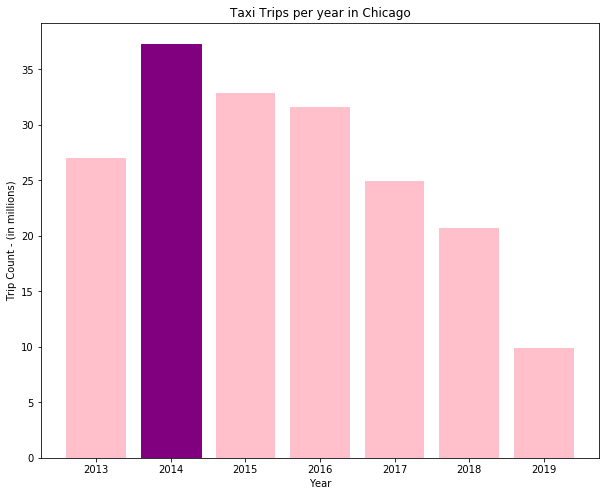

In [50]:
plt.figure(figsize=(10,8))
barlist = plt.bar(yearly_series.index,yearly_series.TripCount/1000_000,color='pink')
barlist[1].set_color('purple')
plt.title('Taxi Trips per year in Chicago')
plt.xlabel('Year')
plt.ylabel('Trip Count - (in millions)');

**2014 had  the most number of Taxi Trips**

### Analyze Taxi usage per month

In [52]:
QUERY = ('''
    SELECT EXTRACT(ISOYEAR FROM trip_start_timestamp) as year,
    EXTRACT(MONTH FROM trip_start_timestamp) as month,
    count(*) as TripCount
    FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
    GROUP BY year,month
    ORDER by year 
''')

query_job = client.query(QUERY)
monthly_total_trips= query_job.to_dataframe()
monthly_total_trips.head()

,year,month,TripCount
0,2013,4,2116671
1,2013,10,2569452
2,2013,6,2386408
3,2013,5,2260977
4,2013,7,2302623


In [77]:
monthly_series = monthly_total_trips.set_index(['month','year']).unstack()
monthly_series = monthly_series/1_000_000
monthly_series

TripCount                                                            
year       2013      2014      2015      2016      2017      2018      2019
month                                                                      
1      1.590062  2.458586  2.879372  2.343331  1.913660  1.647952  1.213529
2      1.800402  2.509506  2.703988  2.568474  1.909802  1.601481  1.312782
3      2.261377  3.118627  2.993568  2.851135  2.362105  1.955818  1.515772
4      2.116671  3.075755  2.809652  2.854319  2.194702  1.864273  1.458362
5      2.260977  3.478535  3.042906  2.859163  2.323386  1.921215  1.532337
6      2.386408  3.474914  2.884799  2.841888  2.324472  1.972813  1.491272
7      2.302623  3.314074  2.678885  2.683274  2.054299  1.652548  1.319231
8      2.410602  3.395979  2.643850  2.629894  2.079861  1.707918  0.000129
9      2.342649  3.257545  2.561293  2.533050  1.950631  1.594710       NaN
10     2.569452  3.510897  2.702021  2.725782  2.141197  1.792710       NaN
11     2.529306  2.956885  2.366081  2.388337  1.907997  1.577804       NaN
12     2.472699  2.776478  2.587095  2.313611  1.767480  1.406692  0.036154

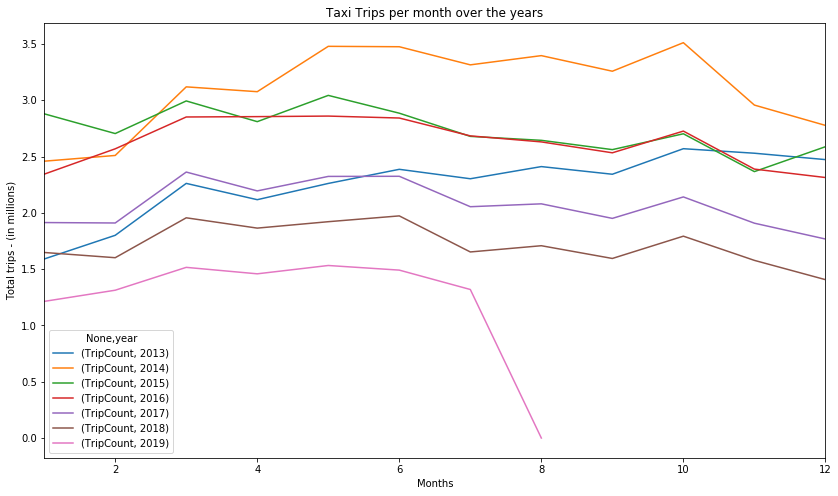

In [93]:
monthly_series.plot(figsize=(14,8))
#plt.plot(monthly_series)
plt.title('Taxi Trips per month over the years')
plt.xlabel('Months')
plt.ylabel('Total trips - (in millions)');

**Generally Taxi usage picks up during the month of October and June**

### Which day of the week has the most taxi usage?

In [108]:
QUERY = ('''
    SELECT EXTRACT(DAYOFWEEK FROM trip_start_timestamp) as DAY,
    count(*) as TripCount
    FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
    GROUP BY day
    ORDER by day 
''')

query_job = client.query(QUERY)
daily_total_trips= query_job.to_dataframe()
daily_total_trips

,DAY,TripCount
0,1,22555093
1,2,23474667
2,3,25393209
3,4,26655489
4,5,28258804
5,6,30551053
6,7,27433556


In [109]:
day_dict = {1:'Sunday',
           2:'Monday',
           3:'Tuesday',
           4:'Wednesday',
           5:'Thursday',
           6:'Friday',
           7:'Saturday'}

In [111]:
daily_total_trips['DAY'].map(day_dict).values

array(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
       'Saturday'], dtype=object)

In [112]:
daily_total_trips['DAY'] = daily_total_trips['DAY'].map(day_dict).values
daily_total_trips

,DAY,TripCount
0,Sunday,22555093
1,Monday,23474667
2,Tuesday,25393209
3,Wednesday,26655489
4,Thursday,28258804
5,Friday,30551053
6,Saturday,27433556


In [113]:
daily_total_trips = daily_total_trips.set_index(['DAY'])

Text(0, 0.5, 'Trip Count - (in millions)')

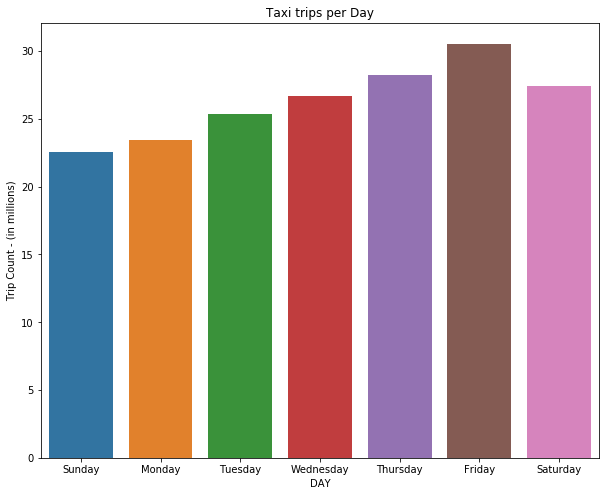

In [121]:
plt.figure(figsize=(10,8))
sns.barplot(daily_total_trips.index,daily_total_trips.TripCount/1_000_000);
plt.title('Taxi trips per Day')
plt.ylabel('Trip Count - (in millions)')


**Friday has he most number of Taxi Trips**


### Market Share per company in terms of trip count

In [137]:
QUERY = ('''
    SELECT company,
    count(*) as TripCount
    FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
    GROUP BY company
    ORDER by TripCount desc
''')

query_job = client.query(QUERY)
company_total_trips= query_job.to_dataframe()
company_total_trips.head(15)

,company,TripCount
0,Taxi Affiliation Services,37919273
1,None,33593407
2,Flash Cab,15794473
3,Dispatch Taxi Affiliation,10429966
4,Yellow Cab,10068857
5,Blue Ribbon Taxi Association Inc.,9496195
6,Choice Taxi Association,7439715
7,Chicago Carriage Cab Corp,7043204
8,Chicago Elite Cab Corp. (Chicago Carriag,5264156
9,City Service,4605112


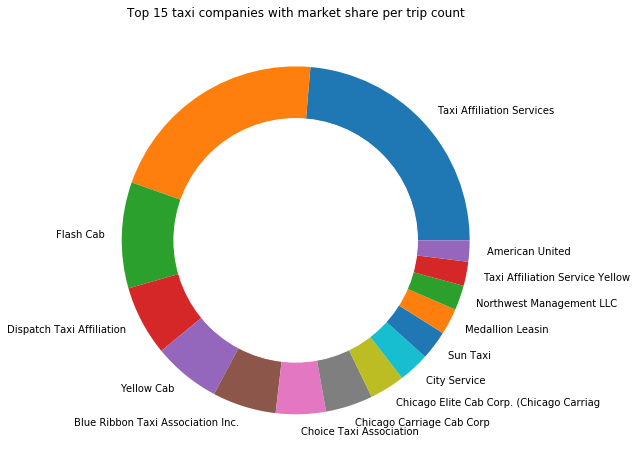

In [138]:
top = company_total_trips[:15]
# Create a pieplot
plt.figure(figsize=(10,8))
plt.pie(top.set_index('company').values,labels=top.company.values)
#plt.show()
 
# add a circle at the center
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Top 15 taxi companies with market share per trip count')
plt.show()


### Market Share per company in terms of revenue

In [141]:
QUERY = ('''
    SELECT company,
    sum(trip_total) as TotalRevenue
    FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
    GROUP BY company
    ORDER by TotalRevenue desc
''')

query_job = client.query(QUERY)
company_total_revenue= query_job.to_dataframe()
company_total_revenue.head(15)

,company,TotalRevenue
0,Taxi Affiliation Services,5.554077e+08
1,None,5.007200e+08
2,Flash Cab,2.438000e+08
3,Dispatch Taxi Affiliation,1.453380e+08
4,Yellow Cab,1.448470e+08
5,Blue Ribbon Taxi Association Inc.,1.324707e+08
6,Chicago Carriage Cab Corp,1.219060e+08
7,Choice Taxi Association,1.165263e+08
8,Chicago Elite Cab Corp. (Chicago Carriag,1.040314e+08
9,City Service,7.847535e+07


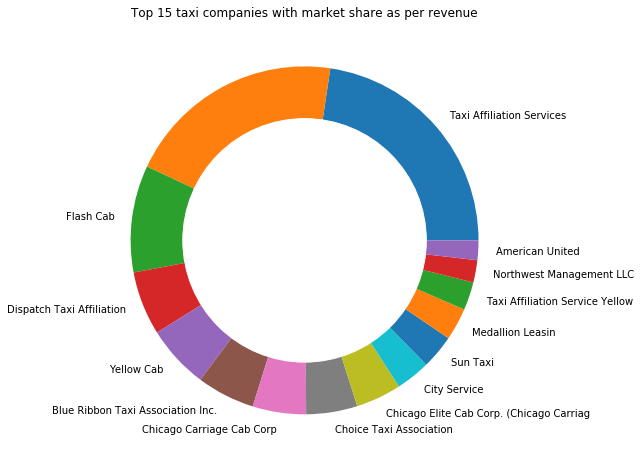

In [142]:
top = company_total_revenue[:15]
# Create a pieplot
plt.figure(figsize=(10,8))
plt.pie(top.set_index('company').values,labels=top.company.values)
#plt.show()
 
# add a circle at the center
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Top 15 taxi companies with market share as per revenue')
plt.show()

### Top 10 most busiest locations (pickup or dropoff)

In [145]:
QUERY = ('''
    SELECT pickup_community_area,
    count(*) as TripCount
    FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
    GROUP BY pickup_community_area
    ORDER by TripCount desc
''')

query_job = client.query(QUERY)
pickup_location_tripcount= query_job.to_dataframe()
pickup_location_tripcount.head(10)

,pickup_community_area,TripCount
0,8.0,53171470
1,32.0,38251509
2,NaN,22368514
3,28.0,15189657
4,76.0,10964918
5,6.0,9952795
6,7.0,7790370
7,24.0,5166288
8,33.0,4036890
9,56.0,2977189


In [147]:
QUERY = ('''
    SELECT dropoff_community_area,
    count(*) as TripCount
    FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
    GROUP BY dropoff_community_area
    ORDER by TripCount desc
''')

query_job = client.query(QUERY)
dropoff_location_tripcount= query_job.to_dataframe()
dropoff_location_tripcount.head(10)

,dropoff_community_area,TripCount
0,8.0,47921616
1,32.0,32508606
2,NaN,25900383
3,28.0,16262692
4,6.0,10592039
5,7.0,9619294
6,24.0,7124147
7,76.0,6426628
8,33.0,4992811
9,3.0,2990287


**Read community area reference data**

In [190]:
comm_names = pd.read_csv('../CommunityAreaNames.csv')
#comm_names.set_index('id',inplace=True)

In [158]:
pickup_location_tripcount.fillna(0,inplace=True)
pickup_location_tripcount.pickup_community_area = pickup_location_tripcount.pickup_community_area.astype('int')

In [163]:
dropoff_location_tripcount.fillna(0,inplace=True)
dropoff_location_tripcount.dropoff_community_area = dropoff_location_tripcount.dropoff_community_area.astype('int')
dropoff_location_tripcount.head()

,dropoff_community_area,TripCount
0,8,47921616
1,32,32508606
2,0,25900383
3,28,16262692
4,6,10592039


In [186]:
dropoff_location_tripcount.head()

,dropoff_community_area,TripCount,communityName
0,8,47921616,NaN
1,32,32508606,Rogers Park
2,0,25900383,West Ridge
3,28,16262692,Uptown
4,6,10592039,Lincoln Square


In [187]:
pickup_location_tripcount.head()

,pickup_community_area,TripCount,communityName
0,8,53171470,NaN
1,32,38251509,Rogers Park
2,0,22368514,West Ridge
3,28,15189657,Uptown
4,76,10964918,Lincoln Square


In [193]:
left = pickup_location_tripcount
right = comm_names
pickup_location_tripcount = pd.merge(left,right,left_on='pickup_community_area',right_on='id')

In [194]:
left = dropoff_location_tripcount
right = comm_names
dropoff_location_tripcount = pd.merge(left,right,left_on='dropoff_community_area',right_on='id')

In [195]:
pickup_location_tripcount.head()

,pickup_community_area,TripCount,communityName,id,AreaName
0,8,53171470,NaN,8,Near North Side
1,32,38251509,Rogers Park,32,Loop
2,28,15189657,Uptown,28,Near West Side
3,76,10964918,Lincoln Square,76,O'Hare
4,6,9952795,North Center,6,Lakeview


In [196]:
dropoff_location_tripcount.head()

,dropoff_community_area,TripCount,communityName,id,AreaName
0,8,47921616,NaN,8,Near North Side
1,32,32508606,Rogers Park,32,Loop
2,28,16262692,Uptown,28,Near West Side
3,6,10592039,Lincoln Square,6,Lakeview
4,7,9619294,North Center,7,Lincoln Park


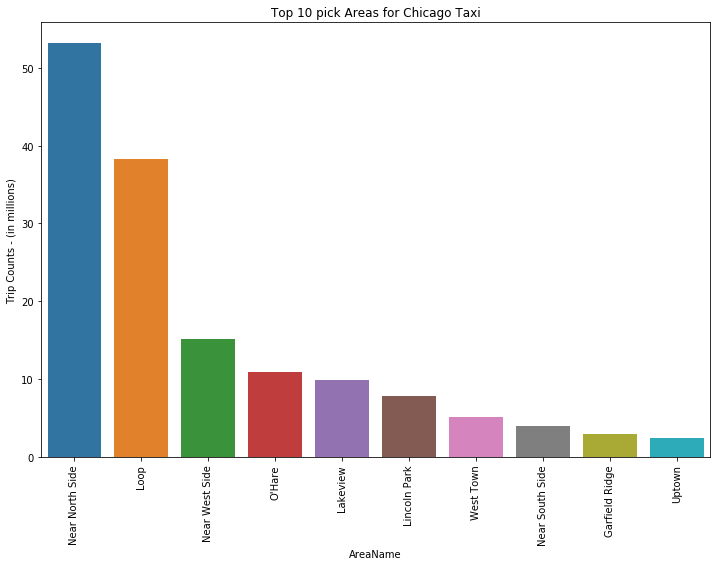

In [206]:
top_pickup = pickup_location_tripcount[:10]
plt.figure(figsize=(12,8))
sns.barplot(top_pickup.AreaName,top_pickup.TripCount/1_000_000);
plt.title('Top 10 Pick Up Areas for Chicago Taxi')
plt.ylabel('Trip Counts - (in millions)')
plt.xticks(rotation=90);


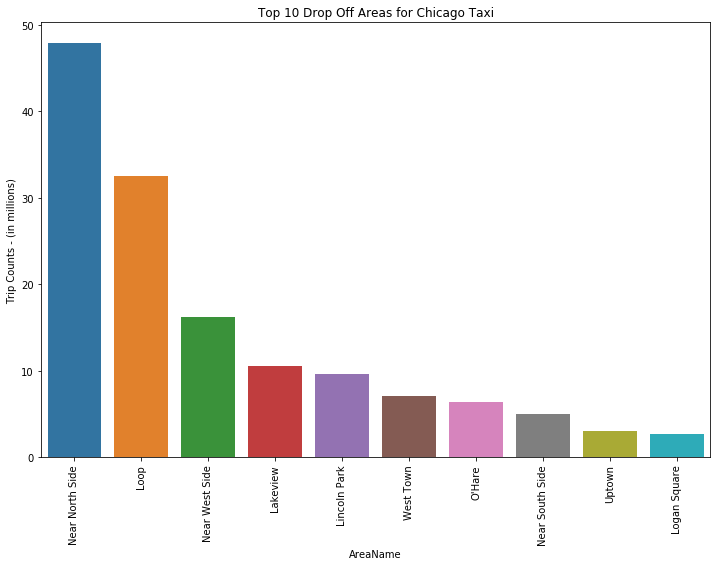

In [207]:
top_pickup = dropoff_location_tripcount[:10]
plt.figure(figsize=(12,8))
sns.barplot(top_pickup.AreaName,top_pickup.TripCount/1_000_000);
plt.title('Top 10 Drop Off Areas for Chicago Taxi')
plt.ylabel('Trip Counts - (in millions)')
plt.xticks(rotation=90);
